Jigar Thummar - 002481709 \
Assignment - 1 \
March 8th, 2025

In [ ]:
# !pip install elpv-dataset efficientnet_pytorch opencv-python

In [33]:
!nvidia-smi

Sat Mar  8 22:31:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0              55W / 300W |   6337MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
# import the libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from elpv_dataset.utils import load_dataset

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import cv2

In [136]:
# Define constants
BATCH_SIZE = 32
NUM_WORKERS = 4
INPUT_SIZE = 240  # EfficientNet-B1 input size
NUM_CLASSES = 2
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4

In [137]:
# change the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
# load the data
images, proba, types = load_dataset()

In [139]:
# Empty the vram
torch.cuda.empty_cache()

In [140]:
# Shape of images
images.shape

(2624, 300, 300)

In [141]:
images[1]

array([[29, 29, 29, ..., 17, 16,  3],
       [29, 29, 29, ..., 17, 16,  3],
       [29, 29, 29, ..., 16, 15,  3],
       ...,
       [21, 22, 21, ..., 12, 12, 11],
       [20, 20, 20, ..., 12, 12, 11],
       [19, 19, 18, ..., 12, 12, 10]], dtype=uint8)

In [142]:
# Probabilities of damaged PV
np.unique(proba)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [143]:
# Types of PV
np.unique(types)

array(['mono', 'poly'], dtype='<U4')

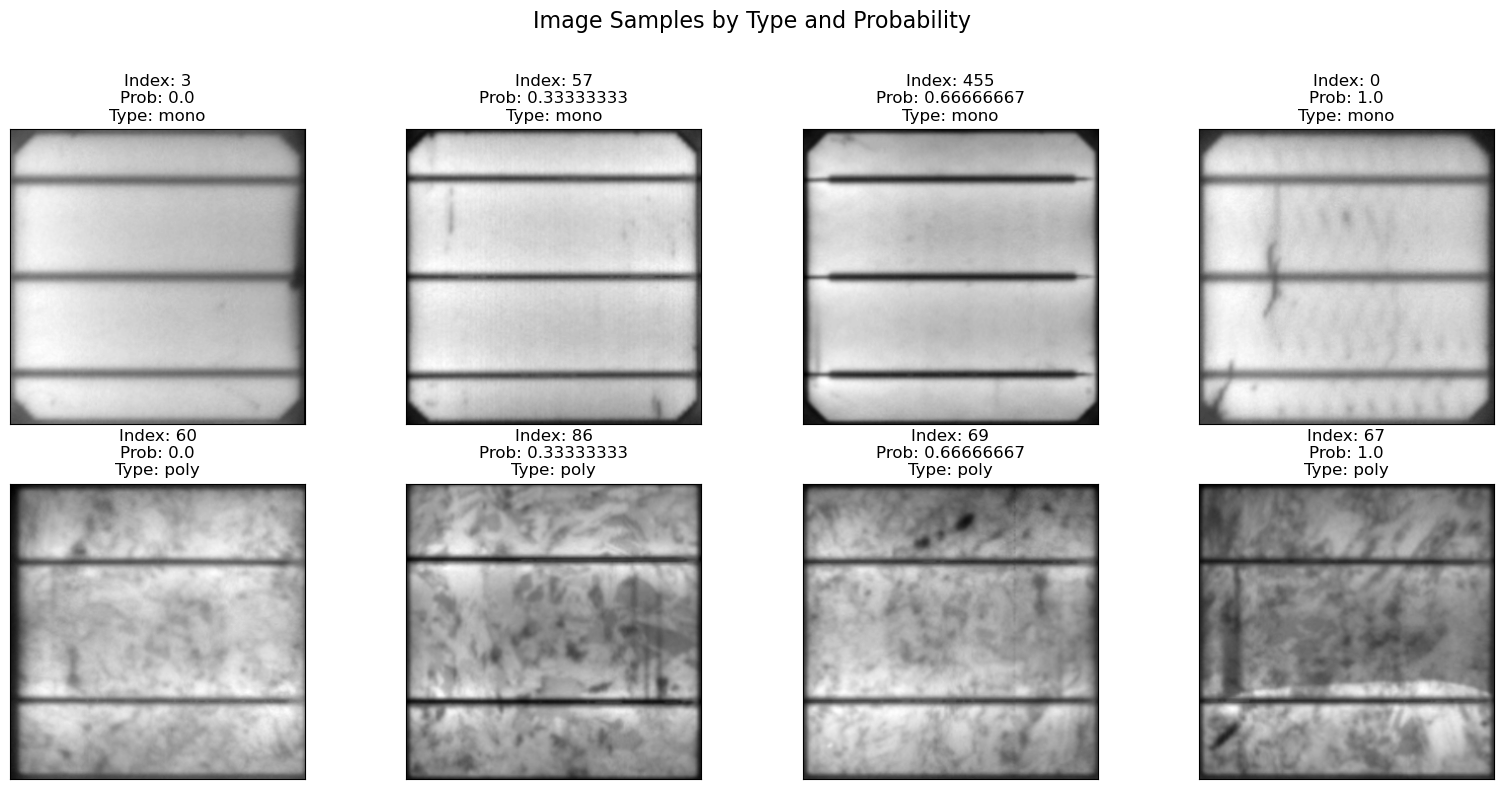

In [144]:
# print images for each type
probabilities = np.array([0.0, 0.33333333, 0.66666667, 1.0])
unique_types = np.array(['mono', 'poly'])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (type_name, prob_value) in enumerate([(t, p) for t in unique_types for p in probabilities]):
    ax = axes[i]
    type_mask = types == type_name
    type_indices = np.where(type_mask)[0]
    type_probas = proba[type_mask]
    closest_idx = type_indices[np.argmin(np.abs(type_probas - prob_value))]
    ax.imshow(images[closest_idx], cmap='gray')
    ax.set_title(f"Index: {closest_idx}\nProb: {prob_value}\nType: {type_name}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Image Samples by Type and Probability", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [145]:
# Create a dataframe
df = pd.DataFrame({
    'type': types,
    'probability': proba
})

# Get unique values
unique_types = np.unique(types)
unique_probs = np.unique(proba)

# Create a cross-tabulation of types vs probabilities
result = pd.crosstab(df['type'], df['probability'])

# Add row and column totals
result.loc['Total'] = result.sum()
result['Total'] = result.sum(axis=1)

# Display the result
print("Distribution of images by type and defect probability:")
print("----------------------------------------------------")
print(result)
print("\nTotal images:", len(images))

Distribution of images by type and defect probability:
----------------------------------------------------
probability   0.0  0.333333  0.666667  1.0  Total
type                                             
mono          588       117        56  313   1074
poly          920       178        50  402   1550
Total        1508       295       106  715   2624

Total images: 2624


In [147]:
# Because there is not much data for each class, we will do binary classification
labels = np.array([0 if p == 0 else 1 for p in proba])

In [148]:
labels[labels==1].shape

(1116,)

In [149]:
labels[labels==0].shape

(1508,)

# Preprocessing

In [151]:
# Custom Dataset class


class SolarPVDataset(Dataset):
    def __init__(self, images, labels, transform=None, apply_clahe=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.apply_clahe = apply_clahe
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        
        # Apply CLAHE preprocessing if specified
        if self.apply_clahe:
            img = img.astype('uint8')
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
            # img = np.stack([img] * 3, axis=-1)
        
        # Convert the numpy array (grayscale) to a PIL image
        image = Image.fromarray(img)
        label = int(self.labels[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [152]:
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]

In [153]:
# Transformations for the images to be used in the model
data_transforms = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR), # resize to 255
    transforms.CenterCrop(240), # crop to 240
    transforms.Grayscale(num_output_channels=3),  # Converting grayscale to 3 channels
    transforms.ToTensor(),  # This scales to [0-1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as in training
])
# Reference: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b1.html#torchvision.models.efficientnet_b1

In [154]:
# Split the dataset into training, validation, and test sets (70% train, 15% validation, 15% test)
indices = np.arange(len(images))

# First split: 70% train, 30% temp (which will be further split into validation and test)
train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)

# Second split: Split the temporary set into validation (15% of total) and test (15% of total)
# To get a 50-50 split of the temp set (which is 30% of the total), we use test_size=0.5
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)

In [155]:
# Create datasets
train_dataset = SolarPVDataset(images[train_idx], labels[train_idx], transform=data_transforms, apply_clahe=True)
val_dataset = SolarPVDataset(images[val_idx], labels[val_idx], transform=data_transforms, apply_clahe=True)
test_dataset = SolarPVDataset(images[test_idx], labels[test_idx], transform=data_transforms, apply_clahe=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Print dataset splits
print(f"Dataset splits: Train={len(train_dataset)} ({len(train_dataset)/len(images):.1%}), "
      f"Validation={len(val_dataset)} ({len(val_dataset)/len(images):.1%}), "
      f"Test={len(test_dataset)} ({len(test_dataset)/len(images):.1%})")

Dataset splits: Train=1836 (70.0%), Validation=394 (15.0%), Test=394 (15.0%)


In [156]:
train_dataset[1]

(tensor([[[ 0.4508,  0.4679,  0.4508,  ...,  0.0056, -0.0629, -0.1486],
          [ 0.5878,  0.6049,  0.5707,  ...,  0.1426,  0.0741, -0.0629],
          [ 0.5707,  0.5707,  0.5707,  ...,  0.2453,  0.1939,  0.0569],
          ...,
          [ 1.2043,  1.2385,  1.2385,  ...,  1.1872,  1.0844,  0.8789],
          [ 1.1872,  1.1700,  1.1358,  ...,  1.1700,  1.0673,  0.8789],
          [ 1.1529,  1.0844,  1.0159,  ...,  1.1529,  1.0331,  0.8276]],
 
         [[ 0.5903,  0.6078,  0.5903,  ...,  0.1352,  0.0651, -0.0224],
          [ 0.7304,  0.7479,  0.7129,  ...,  0.2752,  0.2052,  0.0651],
          [ 0.7129,  0.7129,  0.7129,  ...,  0.3803,  0.3277,  0.1877],
          ...,
          [ 1.3606,  1.3957,  1.3957,  ...,  1.3431,  1.2381,  1.0280],
          [ 1.3431,  1.3256,  1.2906,  ...,  1.3256,  1.2206,  1.0280],
          [ 1.3081,  1.2381,  1.1681,  ...,  1.3081,  1.1856,  0.9755]],
 
         [[ 0.8099,  0.8274,  0.8099,  ...,  0.3568,  0.2871,  0.1999],
          [ 0.9494,  0.9668,

# Training

In [157]:
# Load a pre-trained EfficientNet-B1 and modify the classifier head for 2-class classification
model = EfficientNet.from_pretrained('efficientnet-b1')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 1)
model = model.to(device)

print(f"Using EfficientNet-B1 with {sum(p.numel() for p in model.parameters())} parameters")

Loaded pretrained weights for efficientnet-b1
Using EfficientNet-B1 with 6514465 parameters


In [159]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss() # for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # optimizer


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Still minimizing loss
    factor=0.1,      # Reduce LR by factor of 10
    patience=2,      # Wait 2 epochs with no improvement
    threshold=0.01,  # Smaller threshold for binary task
    min_lr=1e-6      # Don't let LR get too small
)


In [160]:
# Initialize lists to store losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training Loop without early stopping logic
for epoch in range(NUM_EPOCHS):
    ##### Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    
    # Add tqdm progress bar for training
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images_batch, labels_batch in train_bar:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        # Ensure labels are properly shaped for binary classification
        labels_batch = labels_batch.float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item() * images_batch.size(0)
        # Binary prediction (threshold at 0.5 after sigmoid)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels_batch).sum().item()
        
        # Update progress bar with current loss
        train_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)
    
    ##### Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_preds = []
    val_targets = []
    
    # Add tqdm progress bar for validation
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]")
    with torch.no_grad():
        for images_batch, labels_batch in val_bar:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            # Ensure labels are properly shaped for binary classification
            labels_batch = labels_batch.float().view(-1, 1)
            
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Update statistics
            val_loss += loss.item() * images_batch.size(0)
            # Binary prediction (threshold at 0.5 after sigmoid)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels_batch).sum().item()
            
            # Store predictions and targets for metrics calculation
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels_batch.cpu().numpy())
            
            # Update progress bar with current loss
            val_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_correct / len(val_dataset)

    # Store losses and accuracies
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_acc)
    val_accs.append(epoch_val_acc)
    
    # Step the scheduler
    scheduler.step(epoch_val_loss)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch results with learning rate
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss = {epoch_loss:.4f}, Train Acc = {epoch_acc:.4f}, "
          f"Val Loss = {epoch_val_loss:.4f}, Val Acc = {epoch_val_acc:.4f}, "
          f"LR = {current_lr:.6f}")
    
    # Save the model checkpoint after each epoch if desired
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': epoch_val_loss,
    }, f'model_checkpoint_epoch_{epoch+1}.pth')

Epoch 1/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.01it/s, loss=0.6197]


Epoch 1/20: Train Loss = 0.5950, Train Acc = 0.6917, Val Loss = 0.6101, Val Acc = 0.6929, LR = 0.000100


Epoch 2/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.76it/s, loss=0.4634]


Epoch 2/20: Train Loss = 0.4741, Train Acc = 0.7702, Val Loss = 0.5362, Val Acc = 0.7487, LR = 0.000100


Epoch 3/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.48it/s, loss=0.4360]


Epoch 3/20: Train Loss = 0.3695, Train Acc = 0.8312, Val Loss = 0.4947, Val Acc = 0.7589, LR = 0.000100


Epoch 4/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.70it/s, loss=0.6650]


Epoch 4/20: Train Loss = 0.2813, Train Acc = 0.8943, Val Loss = 0.5012, Val Acc = 0.7665, LR = 0.000100


Epoch 5/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.91it/s, loss=0.7070]


Epoch 5/20: Train Loss = 0.1989, Train Acc = 0.9281, Val Loss = 0.4958, Val Acc = 0.7462, LR = 0.000100


Epoch 6/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.95it/s, loss=0.6194]


Epoch 6/20: Train Loss = 0.1291, Train Acc = 0.9559, Val Loss = 0.5219, Val Acc = 0.7437, LR = 0.000010


Epoch 7/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00,  9.94it/s, loss=0.6974]


Epoch 7/20: Train Loss = 0.0904, Train Acc = 0.9766, Val Loss = 0.5189, Val Acc = 0.7487, LR = 0.000010


Epoch 8/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 11.05it/s, loss=0.7411]


Epoch 8/20: Train Loss = 0.0893, Train Acc = 0.9766, Val Loss = 0.5197, Val Acc = 0.7716, LR = 0.000010


Epoch 9/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 11.17it/s, loss=0.7222]


Epoch 9/20: Train Loss = 0.0809, Train Acc = 0.9798, Val Loss = 0.4978, Val Acc = 0.7893, LR = 0.000001


Epoch 10/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s, loss=0.5857]


Epoch 10/20: Train Loss = 0.0720, Train Acc = 0.9809, Val Loss = 0.4693, Val Acc = 0.8046, LR = 0.000001


Epoch 11/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 11.40it/s, loss=0.4651]


Epoch 11/20: Train Loss = 0.0806, Train Acc = 0.9771, Val Loss = 0.4418, Val Acc = 0.8173, LR = 0.000001


Epoch 12/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.67it/s, loss=0.4028]


Epoch 12/20: Train Loss = 0.0714, Train Acc = 0.9815, Val Loss = 0.4262, Val Acc = 0.8274, LR = 0.000001


Epoch 13/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 11.16it/s, loss=0.3920]


Epoch 13/20: Train Loss = 0.0755, Train Acc = 0.9782, Val Loss = 0.4272, Val Acc = 0.8401, LR = 0.000001


Epoch 14/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.67it/s, loss=0.4136]


Epoch 14/20: Train Loss = 0.0686, Train Acc = 0.9815, Val Loss = 0.4377, Val Acc = 0.8401, LR = 0.000001


Epoch 15/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s, loss=0.4501]


Epoch 15/20: Train Loss = 0.0812, Train Acc = 0.9788, Val Loss = 0.4518, Val Acc = 0.8350, LR = 0.000001


Epoch 16/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.22it/s, loss=0.4808]


Epoch 16/20: Train Loss = 0.0790, Train Acc = 0.9782, Val Loss = 0.4636, Val Acc = 0.8376, LR = 0.000001


Epoch 17/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.52it/s, loss=0.5142]


Epoch 17/20: Train Loss = 0.0692, Train Acc = 0.9815, Val Loss = 0.4713, Val Acc = 0.8426, LR = 0.000001


Epoch 18/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.43it/s, loss=0.5355]


Epoch 18/20: Train Loss = 0.0700, Train Acc = 0.9837, Val Loss = 0.4743, Val Acc = 0.8452, LR = 0.000001


Epoch 19/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.59it/s, loss=0.5663]


Epoch 19/20: Train Loss = 0.0725, Train Acc = 0.9837, Val Loss = 0.4796, Val Acc = 0.8452, LR = 0.000001


Epoch 20/20 [Valid]: 100%|██████████| 13/13 [00:01<00:00, 10.92it/s, loss=0.5629]


Epoch 20/20: Train Loss = 0.0654, Train Acc = 0.9847, Val Loss = 0.4802, Val Acc = 0.8426, LR = 0.000001


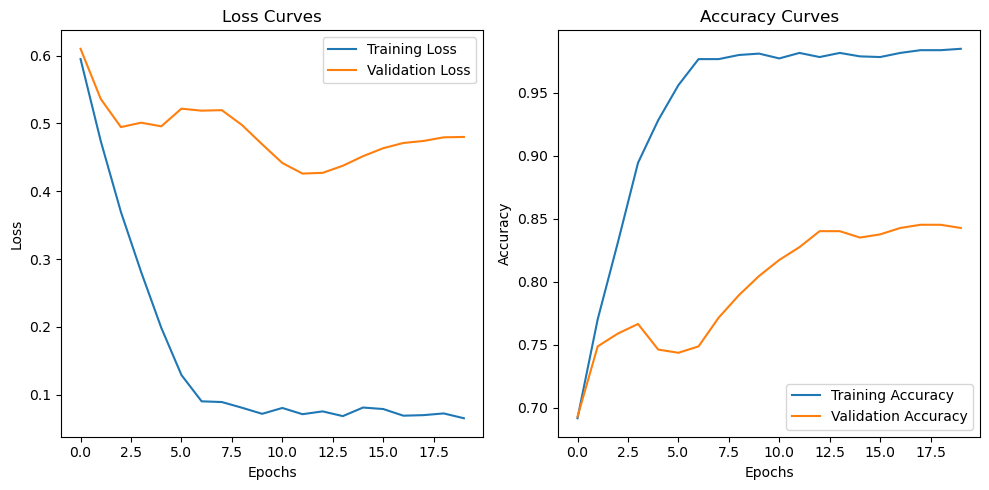

In [161]:

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

# Evaluating

In [162]:
def load_best_model(model_path, model, device):
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [163]:
# Set model to evaluation mode
model.eval()
test_preds = []
test_targets = []

best_model_path = 'model_checkpoint_epoch_19.pth'  # Replace X with your best epoch
model = load_best_model(best_model_path, model, device)

# No gradient calculation for inference
with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        # Ensure labels have the correct shape for binary classification
        labels_batch = labels_batch.float().view(-1, 1)
        outputs = model(images_batch)
        # Apply sigmoid and threshold at 0.4 to obtain binary predictions
        preds = (torch.sigmoid(outputs) > 0.4).float()
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels_batch.cpu().numpy())

# Convert lists to numpy arrays and flatten them
test_preds = np.array(test_preds).flatten().astype(int)
test_targets = np.array(test_targets).flatten().astype(int)

# Generate and print the classification report
print("Classification Report on Test Set:")
print(classification_report(test_targets, test_preds, target_names=["Class 0", "Class 1"]))
print(confusion_matrix(test_targets, test_preds))

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88       227
     Class 1       0.84      0.83      0.83       167

    accuracy                           0.86       394
   macro avg       0.86      0.86      0.86       394
weighted avg       0.86      0.86      0.86       394

[[200  27]
 [ 28 139]]


## Prediction examples

Predicted: Normal, Probability: 0.1098, True Label: Normal


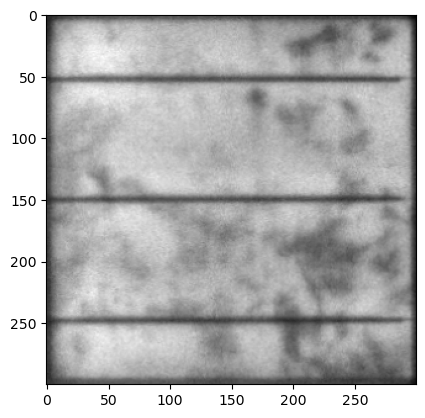

In [164]:
img, label = test_dataset[8]  # Get image & label
img = img.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(img)
    prob = torch.sigmoid(output).item()
    prediction = 1 if prob > 0.4 else 0

image_pil = Image.fromarray(test_dataset.images[8])
print(f"Predicted: {'Damaged' if prediction == 1 else 'Normal'}, Probability: {prob:.4f}, True Label: {'Damaged' if label == 1 else 'Normal'}")
plt.imshow(image_pil, cmap='gray')

Predicted: Damaged, Probability: 0.9884, True Label: Damaged


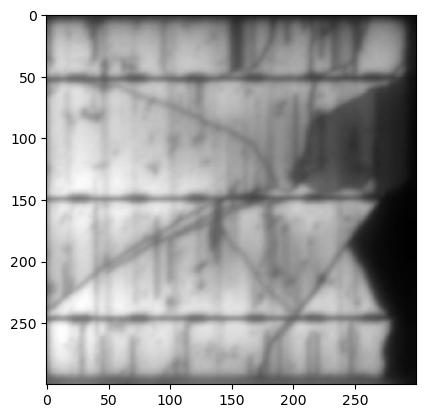

In [165]:
img, label = test_dataset[7]  # Get image & label
img = img.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(img)
    prob = torch.sigmoid(output).item()
    prediction = 1 if prob > 0.4 else 0

image_pil = Image.fromarray(test_dataset.images[7])
print(f"Predicted: {'Damaged' if prediction == 1 else 'Normal'}, Probability: {prob:.4f}, True Label: {'Damaged' if label == 1 else 'Normal'}")
plt.imshow(image_pil, cmap='gray')

Predicted: Normal, Probability: 0.0688, True Label: Normal


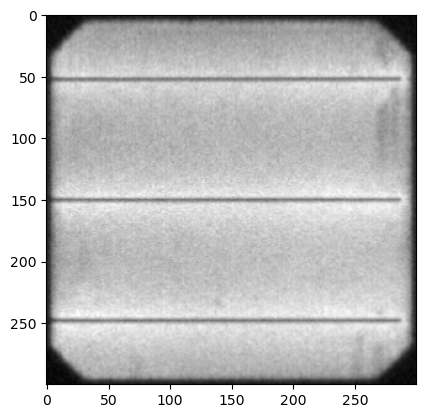

In [166]:
img, label = test_dataset[11]  # Get image & label
img = img.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(img)
    prob = torch.sigmoid(output).item()
    prediction = 1 if prob > 0.4 else 0

image_pil = Image.fromarray(test_dataset.images[11])
print(f"Predicted: {'Damaged' if prediction == 1 else 'Normal'}, Probability: {prob:.4f}, True Label: {'Damaged' if label == 1 else 'Normal'}")
plt.imshow(image_pil, cmap='gray')

Predicted: Damaged, Probability: 0.9946, True Label: Damaged


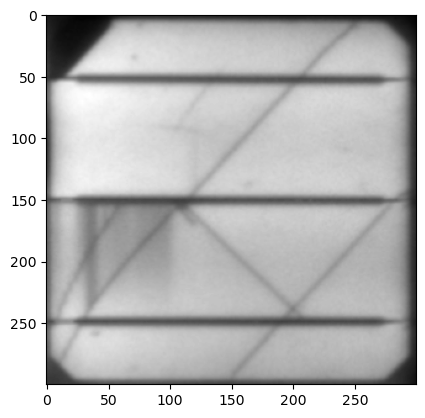

In [167]:
img, label = test_dataset[17]  # Get image & label
img = img.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(img)
    prob = torch.sigmoid(output).item()
    prediction = 1 if prob > 0.4 else 0

image_pil = Image.fromarray(test_dataset.images[17])
print(f"Predicted: {'Damaged' if prediction == 1 else 'Normal'}, Probability: {prob:.4f}, True Label: {'Damaged' if label == 1 else 'Normal'}")
plt.imshow(image_pil, cmap='gray')

Predicted: Damaged, Probability: 0.8051, True Label: Damaged


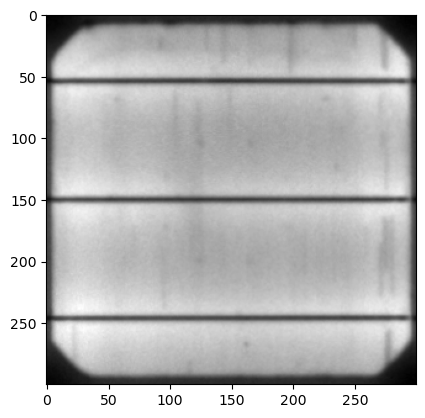

In [168]:
img, label = test_dataset[26]  # Get image & label
img = img.unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(img)
    prob = torch.sigmoid(output).item()
    prediction = 1 if prob > 0.4 else 0

image_pil = Image.fromarray(test_dataset.images[26])
print(f"Predicted: {'Damaged' if prediction == 1 else 'Normal'}, Probability: {prob:.4f}, True Label: {'Damaged' if label == 1 else 'Normal'}")
plt.imshow(image_pil, cmap='gray')